In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
df = pd.read_csv('/Users/natalia/Downloads/summer_camp_data - summer_camp_data.csv', parse_dates=[0])

In [2]:
df[:3]

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0


In [3]:
print("-- Shape:")
print(df.shape)
print("\n-- NaN values:")
print(df.isna().sum()) # пропущенных значений нет 
print("\n-- dtypes:") # c датой уже разобрались
print(df.dtypes)
print("\n-- nuinque:")
print(df.nunique())

-- Shape:
(52721, 14)

-- NaN values:
date                  0
source                0
medium                0
delivery_available    0
device_type           0
promo_activated       0
filter_used           0
pageviews             0
visits                0
productClick          0
addToCart             0
checkout              0
transactions          0
revenue               0
dtype: int64

-- dtypes:
date                  datetime64[ns]
source                        object
medium                        object
delivery_available            object
device_type                   object
promo_activated               object
filter_used                   object
pageviews                      int64
visits                         int64
productClick                   int64
addToCart                      int64
checkout                       int64
transactions                   int64
revenue                      float64
dtype: object

-- nuinque:
date                    274
source                   24


In [4]:
# проверим нет ли повторных названий
df.source.value_counts()

yandex           11928
google           11793
(direct)          5031
admitad           4210
eLama             3415
cityads           2923
other             2460
newsletter        1680
vk                1425
promo             1178
DuckDuckGo        1135
facebook          1026
co-promo           946
bing               811
actionpay          763
opmcpa             545
mytarget           540
advertise          327
instagram          301
yandex_direct      109
youtube             88
sailplay            49
baidu               19
exponea             19
Name: source, dtype: int64

In [6]:
df.device_type.value_counts()

Мобайл           24416
Десктоп          22919
Не определено     5386
Name: device_type, dtype: int64

### Какой рекламный канал принем больше всего дохода за все время?

In [7]:
# группируем по источнику и суммируем выручку, выбираем максимальный
max_revenue_souce = df.groupby('source') \
    .agg({'revenue':'sum'}) \
    .reset_index() \
    .sort_values('revenue', ascending = False)
max_revenue_souce.head(1)

,source,revenue
21,yandex,467299311.0


### Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

Гуглим когда начались ковидные ограничения: "11 марта 2020 года Россия впервые начала серьёзно ограничивать авиасообщение с ЕС из-за пандемии COVID-19, разрешив летать в некоторые страны. С 30 марта 2020 года Россия полностью закрыла свои границы как для россиян, так и для иностранных граждан". Также, посмотрим по графику когда были пики и падения и попробуем сопоставить информацию.  

In [36]:
# df.date.min() -> 2020-01-01
# df.date.max() -> 2020-09-30

In [9]:
# проверим есть ли аномалии -> 21 строка с 0 выручкой, но транзакции произошли, 
# еще можно заметить что у всех кроме одного был активирован промокод -> возможно это был какой-то подарок
# поэтому удалять их из дата-сета было бы не совсем разумно
df.query('transactions == 0 & revenue != 0 or transactions != 0 & revenue == 0').head(3)

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
20667,2020-09-25,google,cpc,Не определено,Не определено,yes,no,0,5,0,0,0,1,0.0
20771,2020-09-01,promo,email,Не определено,Десктоп,yes,no,16,3,0,0,3,1,0.0
21298,2020-08-12,yandex,organic,Доставки нет,Десктоп,yes,no,15,2,0,0,9,1,0.0


In [10]:
# средняя выручка по дням
mean_revenue = df.groupby(['date'])['revenue'].mean().reset_index()

In [38]:
mean_revenue.head()

,date,revenue
0,2020-01-01,20632.555556
1,2020-01-02,26598.595628
2,2020-01-03,27354.989011
3,2020-01-04,27803.640625
4,2020-01-05,27753.910995


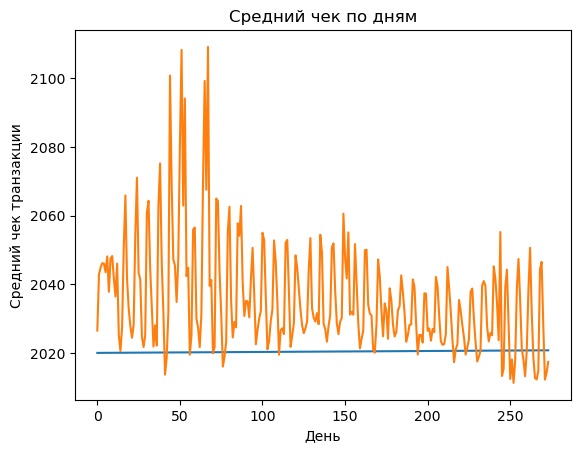

In [39]:
# Создаем график
plt.plot(mean_revenue.index, mean_revenue.values)
plt.title('Средний чек по дням')
plt.xlabel('День')
plt.ylabel('Средний чек транзакции')
plt.show()

In [41]:
mean_revenue.sort_values('revenue', ascending = False).reset_index().head(3)

,index,date,revenue
0,67,2020-03-08,50800.174312
1,51,2020-02-21,50494.618357
2,44,2020-02-14,47753.235808


In [42]:
mean_revenue.sort_values('revenue', ascending = True).reset_index().head(3)

,index,date,revenue
0,252,2020-09-09,15066.867021
1,271,2020-09-28,15422.106796
2,266,2020-09-23,15432.082051


Наблюдается пик выручки 8 марта, что скорее связано с праздником, также пики были и в феврале, сильных падений в марте не наблюдаются, так что оставновимся на 11 марта.

In [40]:
# фильтрация строк по периоду до и после введения ограничений
df_before = df[df['date'] < '2020-03-11']
df_after = df[df['date'] >= '2020-03-11']

# расчет среднего чека транзакции до и после введения ограничений
avg_before = round(df_before['revenue'].mean(), 2)
avg_after = round(df_after['revenue'].mean(), 2)

# вывод результатов
print(f'Средний чек транзакции до ограничений: {avg_before}')
print(f'Средний чек транзакции после ограничений: {avg_after}')

Средний чек транзакции до ограничений: 28281.63
Средний чек транзакции после ограничений: 22911.19


In [15]:
# разделение данных на транзакции с промокодом и без
data_promo = df[df['promo_activated']== 'yes']
data_no_promo = df[df['promo_activated'] == 'no']

# расчет среднего чека транзакции до и после введения ограничений для каждой категории
promo_avg_before = round(data_promo[data_promo['date'] < '2020-03-01']['revenue'].mean(), 2)
promo_avg_after = round(data_promo[data_promo['date'] >= '2020-03-01']['revenue'].mean(), 2)
no_promo_avg_before = round(data_no_promo[data_no_promo['date'] < '2020-03-01']['revenue'].mean(), 2)
no_promo_avg_after = round(data_no_promo[data_no_promo['date'] >= '2020-03-01']['revenue'].mean(), 2)

# вывод результатов
print(f'Средний чек транзакции с промокодом до ограничений: {promo_avg_before}')
print(f'Средний чек транзакции с промокодом после ограничений: {promo_avg_after}')
print(f'Средний чек транзакции без промокода до ограничений: {no_promo_avg_before}')
print(f'Средний чек транзакции без промокода после ограничений: {no_promo_avg_after}')

Средний чек транзакции с промокодом до ограничений: 29146.23
Средний чек транзакции с промокодом после ограничений: 25663.39
Средний чек транзакции без промокода до ограничений: 26499.27
Средний чек транзакции без промокода после ограничений: 21074.32


###  Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?


Помимо деления на выходные дни и рабочие, добавим праздничные дни.

In [16]:
# добавление столбца с днем недели
df['weekday'] = pd.to_datetime(df['date']).dt.weekday

In [17]:
# добавление столбца с признаком праздничного дня
holidays = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06', '2020-01-08',
            '2020-01-07',
            '2020-02-23', 
            '2020-03-08', 
            '2020-05-01', 
            '2020-05-09', 
            '2020-06-12', 
            '2020-11-04']
df['holiday'] = np.where(df['date'].isin(holidays), 1, 0)

In [18]:
# Выделение данных для выходных и будних дней
weekend_data = df.query('weekday in [5,6] or holiday == 1')
weekday_data = df.query('weekday not in [5,6] and holiday == 0')


In [19]:
# Рассчет коэффициента конверсии в транзакцию для каждого набора данных
weekend_cr = weekend_data['transactions'].sum() / weekend_data['visits'].sum()
weekday_cr = weekday_data['transactions'].sum() / weekday_data['visits'].sum()

In [20]:
weekday_cr

0.15141071434750064

In [21]:
weekend_cr

0.17009975396360283

In [22]:
# Вычисление стандартного отклонения и стандартной ошибки для каждого CR
weekday_std = weekday_data['transactions'].std() / weekday_data['visits'].count() ** 0.5
weekend_std = weekend_data['transactions'].std() / weekend_data['visits'].count() ** 0.5


Хоть многие и не любят т-тест, но более "надежные" методы, например, как bootstrap достаточно энергозатратен и не всегла есть смысл его использовать

In [23]:
# Применение двухвыборочного T-теста
t, p = stats.ttest_ind_from_stats(weekday_cr, weekday_std, weekday_data['visits'].count(),
                                  weekend_cr, weekend_std, weekend_data['visits'].count(), equal_var=False)

In [24]:
# Определение результата теста
if p < 0.05:
    print(f"Отличие CR в выходные дни со значением {p} статистически значимо")
else:
    print(f"Отличие CR в выходные дни со значением {p} статистически не значимо")

Отличие CR в выходные дни со значением 1.0929124137834686e-06 статистически значимо


### Вам необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед.
Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам
понадобятся?

Предсказаниями я особо не занималась, но Боже храни гугл и chftGPT, да и эта тема интересна сама по себе.

После гугления, пришла к выводу, что решения для этой задачи можно использовать линейную регрессию. 

Шаги, которые мы будем следовать, чтобы решить эту задачу:

- Подготовить данные (EDA)
- Обучить модель линейной регрессии
- Оценить качество модели
- Сделать прогноз на 6 месяцев вперед

Минимальный EDA мы уже провели. Теперь необходимо определить по каким признакам будем прогнозировать доход.

In [25]:
# отберем только контекстную рекламу и удалим ненужные столбцы
df_cpc = df.query('medium == "cpc"').drop(['medium', 'holiday', 'weekday'], axis=1)

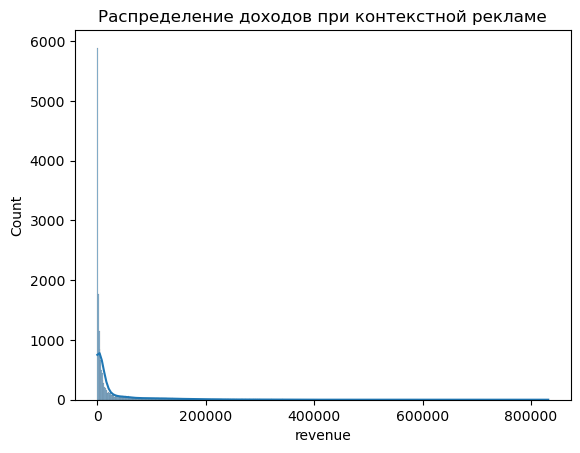

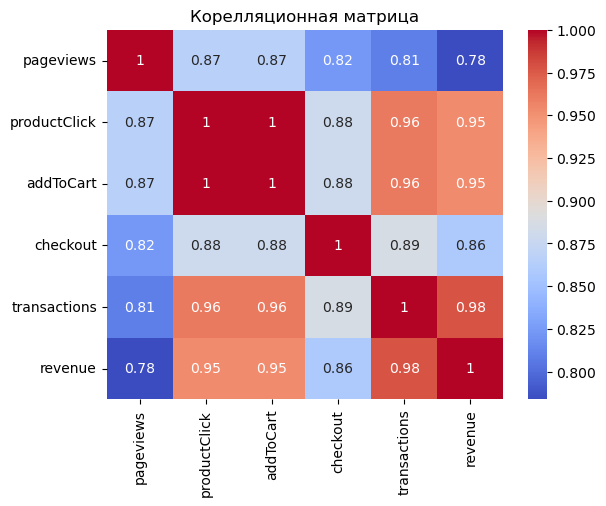

In [35]:
# распределение дохода по контекстной рекламе
sns.histplot(data=df_cpc, x='revenue', kde=True)
plt.title('Распределение доходов при контекстной рекламе')
plt.show()

# корреляционная матрица
corr = df_cpc.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корелляционная матрица')
plt.show()

На первом графике, распределение скошено влево, видим большое значение нулевых значений, поэтому это нужно иметь ввиду при выборе метода. На втором графике, наблюдается сильная корреляция между pageviews, productClick, addToCart, checkout, transactions. Собственно, с признаками определились.

Приступаем к построению модели. Для этого необходимо разделить данные на обучающую и тестовую выборки, выбрать и обучить модель на обучающей выборке, а затем оценить ее качество на тестовой выборке.

In [27]:
# Удаляем ненужных признаков
df_cpc = df_cpc.drop(['date', 'source', 'delivery_available', 'device_type', 'promo_activated', 'filter_used', 'visits'], axis=1)


In [28]:
df_cpc[:3]

,pageviews,productClick,addToCart,checkout,transactions,revenue
1,3302,9930,1984,1416,217,244478.0
2,2970,5460,1090,599,100,105150.0
3,1875,4250,848,407,71,79003.0


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [30]:
# Разбиение данных на обучающую и тестовую выборки
X = df_cpc.drop(['revenue'], axis=1)
y = df_cpc['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Обучение модели линейной регрессии
reg = LinearRegression().fit(X_train, y_train)

In [32]:
# Прогнозирование дохода на тестовой выборке
y_pred = reg.predict(X_test)

In [33]:
# Оценка качества прогнозов
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 125162571.42
Coefficient of determination: 0.96


Значение коэффициента детерминации 0.96 говорит о том, что модель хорошо описывает зависимости между признаками и целевой переменной, а значение среднеквадратической ошибки 125162571.42, что как бы очень много. Это явно связано с тем, что в данных что-то было не учтено, скорее всего выбросы, так как много было 0 значений.

В общем, будет чем заняться на выходных.

Теперь нужно спрогнрзировать на полгода вперед. На этом этапе я погрязла, поэтому похоже не успею сделать к дедлайну :(